In [1]:
#MAP_ID = 703368
MAP_ID = 703326
#MAP_ID = 703323
MIN_THRESHOLD = 0.92

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os
import json
import sys
parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)
from models import Map
sys.path.remove(parent_dir)

with open( "data/maps.json", "r", encoding='utf-8') as f:
    data: dict = json.load(f)
    maps: dict[int, Map] = dict()
    for m in data:
        maps[m["id"]] = Map.from_dict(m)

with open(f"data/walkable-{MAP_ID}.bin", "rb") as bin:
    walkable_image_bytes = bin.read()
    maps[MAP_ID].walkable_image_bytes = walkable_image_bytes

In [3]:
def create_walkable_matrix(map: Map) -> list[list[float]]:
        walkable_matrix = []
        for y in range(map.height):
            row = []
            for x in range(map.width):
                if map.pixel_is_walkable(x, y):
                    row.append(1)
                else:
                    row.append(0)
            walkable_matrix.append(row)
        return walkable_matrix

walkable_matrix = create_walkable_matrix(maps[MAP_ID])

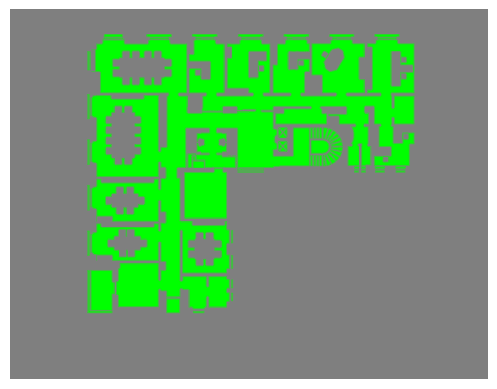

In [4]:
def show_initial_map(map: Map, walkable_matrix: list[list[float]]):

    height = map.height
    width = map.width

    img = np.zeros((height, width, 3))

    for i in range(height):
        for j in range(width):
            if walkable_matrix[i][j] == 0:
                img[i][j] = [0.5, 0.5, 0.5]
            else:
                img[i][j] = [1 - walkable_matrix[i][j], walkable_matrix[i][j], 0]

    plt.imshow(img)
    plt.axis('off')
    plt.show()

show_initial_map(maps[MAP_ID], walkable_matrix)

In [5]:
def compute_horizontal_ratio(walkable_matrix: list[list[float]], tqdm_title: str):
    result = np.zeros_like(walkable_matrix, dtype=float)
    
    for row_index in tqdm(range(len(walkable_matrix)), desc=tqdm_title):
        start_idx = None
        end_idx = None
        
        for i, val in enumerate(walkable_matrix[row_index]):
            if val == 0:
                if start_idx is not None:
                    end_idx = i
                    center_idx = (start_idx + end_idx) // 2
                    
                    for j in range(start_idx, end_idx):
                        distance = abs(j - center_idx)
                        value = 1 - (distance / (end_idx - start_idx))
                        result[row_index][j] = value
                    
                start_idx = None
                end_idx = None
            elif start_idx is None:
                start_idx = i
    
    return result

Computing horizontal ratio: 100%|██████████| 1095/1095 [00:00<00:00, 11525.59it/s]


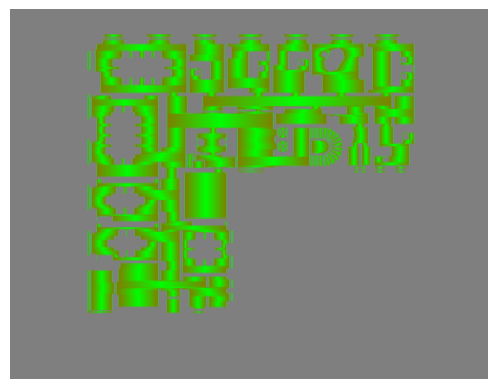

In [6]:
horizontal_wall_ratio_matrix = compute_horizontal_ratio(walkable_matrix, "Computing horizontal ratio")
show_initial_map(maps[MAP_ID], horizontal_wall_ratio_matrix)

Computing vertical ratio: 100%|██████████| 1415/1415 [00:00<00:00, 12992.74it/s]


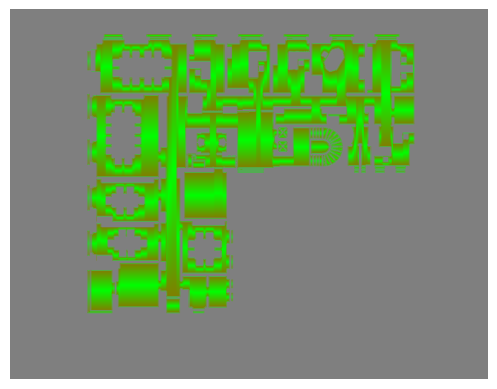

In [7]:
walkable_matrix_transposed = list(map(list, zip(*walkable_matrix)))
vertical_wall_ratio_matrix = compute_horizontal_ratio(walkable_matrix_transposed, "Computing vertical ratio")
vertical_wall_ratio_matrix = list(map(list, zip(*vertical_wall_ratio_matrix)))
show_initial_map(maps[MAP_ID], vertical_wall_ratio_matrix)

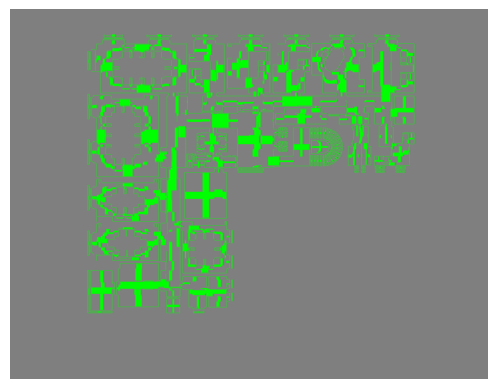

In [8]:
def compute_final_matrix(horizontal_wall_ratio_matrix, vertical_wall_ratio_matrix, MIN_THRESHOLD):
    matrix = np.zeros_like(horizontal_wall_ratio_matrix)
    for i in range(len(horizontal_wall_ratio_matrix)):
        for j in range(len(horizontal_wall_ratio_matrix[i])):
            if horizontal_wall_ratio_matrix[i][j] < MIN_THRESHOLD and vertical_wall_ratio_matrix[i][j] < MIN_THRESHOLD:
                matrix[i][j] = 0
            else:
                matrix[i][j] = 1
    return matrix

final_considering_pixel_matrix = compute_final_matrix(horizontal_wall_ratio_matrix, vertical_wall_ratio_matrix, MIN_THRESHOLD) 
show_initial_map(maps[MAP_ID], final_considering_pixel_matrix)

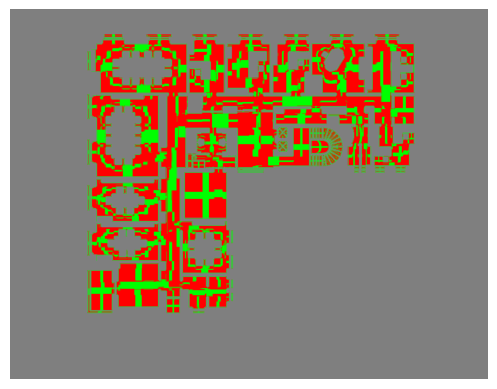

In [9]:
def plot_matrix(map: Map, walkable_matrix, final_considering_pixel_matrix):

    height = map.height
    width = map.width
    img = np.zeros((height, width, 3))

    for i in range(len(walkable_matrix)):
        for j in range(len(walkable_matrix[i])):
            if walkable_matrix[i][j] == 0:
                img[i][j] = [0.5, 0.5, 0.5]
            elif walkable_matrix[i][j] == 1 and final_considering_pixel_matrix[i][j] == 0:
                img[i][j] = [1, 0, 0]
            else:
                img[i][j] = [0, 1, 0]

    # Plot the matrix
    plt.imshow(img)
    plt.axis('off')
    plt.show()

plot_matrix(maps[MAP_ID], walkable_matrix, final_considering_pixel_matrix)